In [2]:
import pandas as pd
import numpy as np
import os
import time
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
TRAIN_DIRECTORY = "../Data/Symptoms/Total/"

#### Read and get the training data

In [4]:
def read_file(filename):
    return pd.read_csv(filename)

def get_training_data(files_):
    data = defaultdict()
    columns = defaultdict()
    for i in files_:
        name = i
        name = name.replace('.csv','')
        data[name] = read_file(TRAIN_DIRECTORY+i)
        columns[name] = list(data[name].columns)
        columns[name].remove('virus')
    return data,columns

In [5]:
# remove the target variable
def remove_target(data_dict):
    for i in data_dict.keys():
        data_dict[i].drop(['virus'],axis = 1,inplace = True)
    return data_dict

In [6]:
#get the entire training data
files_ = ['nyumc.csv','goviral.csv','fluwatch.csv','hongkong.csv','hutterite.csv']
data_,columns_ = get_training_data(files_)
print(data_.keys())
data_ = remove_target(data_)

dict_keys(['goviral', 'nyumc', 'fluwatch', 'hutterite', 'hongkong'])


#### Get the statistical measure of variance

In [7]:
def get_statistical_measure(data_dict):
    data_stats = defaultdict()
    for i in data_dict.keys():
        data_stats[i] = data_dict[i].var(axis = 0)
    return data_stats

In [8]:
data_stats = get_statistical_measure(data_)

* Only consider the positive data points

In [9]:
def only_positive_data_stats(data_dict):
    data_stats = defaultdict()
    for i in data_dict.keys():
        data = data_dict[i]
        data = data.loc[data['virus'] == 1]
        data_stats[i] = data.var(axis = 0)
    return data_stats

#### Distance between the two datasers

In [10]:
#l2 distance
def get_distance(data_stats):

    distance = defaultdict()
    names = list(data_stats)
    for i in names:
        compare_to = [j for j in names if j!=i]
        distance[i] = [(j,np.linalg.norm((np.asarray(data_stats[i]) - np.asarray(data_stats[j])),ord = 2)) for j in compare_to]
    return distance


In [11]:
distance = get_distance(data_stats)

In [12]:
data_,columns = get_training_data(files_)

In [13]:
positive_data_stats = only_positive_data_stats(data_)

In [14]:
positive_distance = get_distance(positive_data_stats)

In [16]:
positive_distance

defaultdict(None,
            {'fluwatch': [('nyumc', 0.5348043558228879),
              ('goviral', 0.6127172664511532),
              ('hutterite', 0.34282434872235323),
              ('hongkong', 0.4258796493148004)],
             'goviral': [('nyumc', 0.5801421371712242),
              ('fluwatch', 0.6127172664511532),
              ('hutterite', 0.46719672058767603),
              ('hongkong', 0.5630107591750226)],
             'hongkong': [('nyumc', 0.4689451106502787),
              ('goviral', 0.5630107591750226),
              ('fluwatch', 0.4258796493148004),
              ('hutterite', 0.39853540486496614)],
             'hutterite': [('nyumc', 0.49182107866895003),
              ('goviral', 0.46719672058767603),
              ('fluwatch', 0.34282434872235323),
              ('hongkong', 0.39853540486496614)],
             'nyumc': [('goviral', 0.5801421371712242),
              ('fluwatch', 0.5348043558228879),
              ('hutterite', 0.49182107866895003),
             

#### Plot the distances

In [17]:
def create_plots(columns,dict_,name,order,label,title):
    df = pd.DataFrame(columns)
    df_list = []
    for i in dict_.keys():
        df_list.append(pd.DataFrame({k:[v] for (k,v) in dict(dict_[i]).items()}))
    df = pd.concat(df_list)
    df.fillna(0,inplace = True)
    df[name] = columns
    df.set_index(name,inplace = True)
    df = df[order]
    sns.set()
    ax = plt.axes()
    sns.heatmap(df,annot=True,linewidth = 0.8,ax = ax,cbar_kws = {'label' : label})
    ax.set_title(title)
    plt.show()
    return df
    

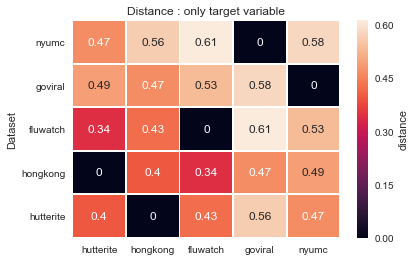

In [18]:
positive_distances = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  positive_distance,
                  'Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'distance',
                  'Distance : only target variable')

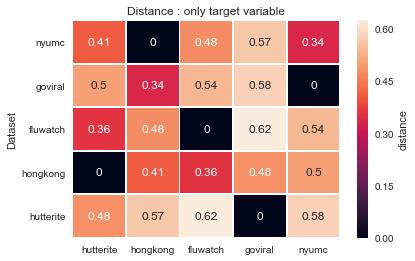

In [16]:
general_distance = create_plots(['nyumc','goviral','fluwatch','hongkong','hutterite'],
                  distance,
                  'Dataset',
                  ['hutterite','hongkong','fluwatch','goviral','nyumc'],'distance',
                  'Distance : only target variable')

** Finding the distance by training a Logisitic Regression to classify between the datasets **

In [34]:
no_datapoints = defaultdict()
datasets = defaultdict()

In [35]:
data_nyumc = read_file(TRAIN_DIRECTORY+'nyumc.csv')
datasets['nyumc'] = data_nyumc
data_nyumc.head()

,fever,sorethroat,cough,muscle,headache,fatigue,vomit,nausea,diarrhea,chills,sneeze,shortness of breath,phlegm,blockednose,earache,leg pain,runnynose,virus
0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
no_datapoints['nyumc'] = data_nyumc.shape[0]

In [36]:
data_gv = read_file(TRAIN_DIRECTORY+'goviral.csv')
datasets['goviral'] = data_gv
data_gv.head()

,fever,sorethroat,cough,muscle,headache,fatigue,vomit,nausea,diarrhea,chills,sneeze,shortness of breath,phlegm,blockednose,earache,leg pain,runnynose,virus
0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1
1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1
2,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1
3,1,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1
4,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1


In [24]:
no_datapoints['goviral'] = data_gv.shape[0]

In [25]:
data_fw = read_file(TRAIN_DIRECTORY+'fluwatch.csv')
data_fw.head()

,fever,sorethroat,cough,muscle,headache,fatigue,vomit,nausea,diarrhea,chills,sneeze,shortness of breath,phlegm,blockednose,earache,leg pain,runnynose,virus
0,1.0,0.0,0.0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,0.0,0,0,1.0,0
1,1.0,1.0,1.0,1.0,1.0,0,0,0,0.0,0,1.0,0,0,0.0,0,0,1.0,0
2,0.0,0.0,1.0,0.0,0.0,0,0,0,0.0,0,1.0,0,0,0.0,0,0,0.0,1
3,0.0,0.0,0.0,0.0,1.0,0,0,0,0.0,0,1.0,0,0,0.0,0,0,1.0,1
4,0.0,1.0,1.0,1.0,1.0,0,0,0,0.0,0,0.0,0,0,1.0,0,0,1.0,1


In [26]:
no_datapoints['fluwatch'] = data_fw.shape[0]

In [27]:
data_hk = read_file(TRAIN_DIRECTORY+'hongkong.csv')
data_hk.head()

,fever,sorethroat,cough,muscle,headache,fatigue,vomit,nausea,diarrhea,chills,sneeze,shortness of breath,phlegm,blockednose,earache,leg pain,runnynose,virus
0,1.0,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,1.0,0,0,0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,1.0,0,0,0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0


In [28]:
no_datapoints['hongkong'] = data_hk.shape[0]

In [29]:
data_ht = read_file(TRAIN_DIRECTORY+'hutterite.csv')
data_ht.head()

,fever,sorethroat,cough,muscle,headache,fatigue,vomit,nausea,diarrhea,chills,sneeze,shortness of breath,phlegm,blockednose,earache,leg pain,runnynose,virus
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0
1,0,1,1,1,1,0,0,0,0,0,0,0,0,1,0.0,0,1,0.0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.0,0,1,0.0
3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0.0
4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0,1,0.0


In [30]:
no_datapoints['hutterite'] = data_ht.shape[0]

In [31]:
print("The number of data points are : \n")
for k,v in no_datapoints.items():
    print(k," : ",v)
    print("_____________________")

The number of data points are : 

hongkong  :  4954
_____________________
nyumc  :  21907
_____________________
hutterite  :  1281
_____________________
fluwatch  :  915
_____________________
goviral  :  520
_____________________


*Sample the positive and the negative examples from the dataset*

In [32]:
def sample(data_,positive = True):
    if positive : 
        data_ = data_.loc[data['virus'] == 1]
        return data_
    else:
        data_ = data.loc[data['virus'] == 0]
        return data_

In [33]:
def separate_class(data_):
    pos = sample(data_,True)
    neg = sample(data_,False)
    return pos,neg

In [ ]:
def separate_classes(data_dict,positive,negative_

In [ ]:
positive = defaultdict()
negative = defaultdict()